# Problem statement 

Given the below table of widths and heights (in pixels) belonging to different figures, using a machine learning algorithm, can you determine if a figure with width 30 and height 22 is considered an anomaly in the above data set?

In [3]:
images = [[25,24],
[25,25],
[25,25],
[21,24],
[24,24],
[30,29],
[25,25],
[25,25],
[27,29],
[25,29],
[24,29],
[24,25],
[27,25],
[24,27],
[24,25],
[25,24],
[24,25],
[25,30],
[29,29],
[27,30],
[27,24],
[29,25],
[27,25],
[25,25],
[23,29]]

In [6]:
import pandas as pd
from numpy import percentile
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import numpy as np
from numpy import linalg

import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.patches as mpatches
from matplotlib import colors as mcolors
from functools import reduce 
import matplotlib.font_manager

from pyod.models.knn import KNN
from pyod.models.auto_encoder import AutoEncoder
from pyod.utils.data import generate_data
from pyod.models.pca import PCA
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.lof import LOF
from pyod.models.loci import LOCI
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.sos import SOS
from pyod.models.lscp import LSCP
from pyod.models.cof import COF

from sklearn.preprocessing import StandardScaler


In [7]:
# image_pixels =  pd.read_csv('pixels.csv')
# append [30,22] to data
images.append([30,22])
image_pixels=pd.DataFrame(images,columns=['width','height'])
image_pixels[image_pixels.width==30]

,width,height
5,30,29
25,30,22
26,30,22
27,30,22


We should always look at the data first. In this case that we only have 26 number of points (i.e. images) including the anomaly data (width=30, height = 22), I did a pair attribution visualization to investigate the data:



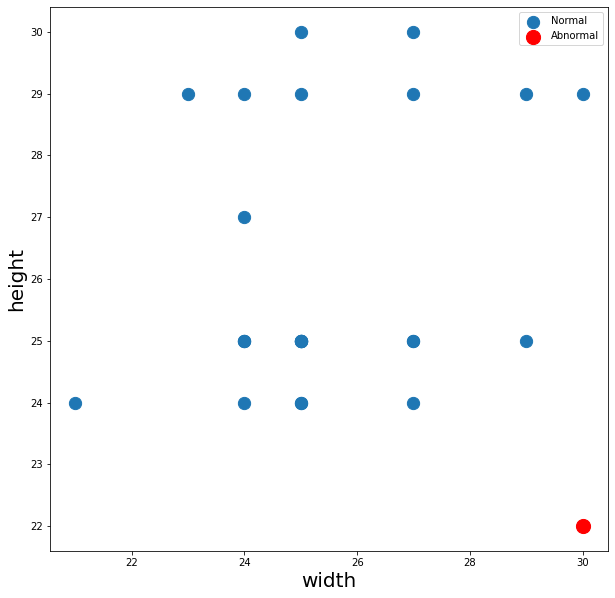

In [8]:
fig,ax = plt.subplots(figsize=(10,10))
ax.scatter(image_pixels.width,image_pixels.height, s=150,label='Normal')
ax.scatter(image_pixels.iloc[25].width,image_pixels.iloc[25].height, s=200, c='r',label='Abnormal')
ax.set_xlabel('width',fontsize=20)
ax.set_ylabel('height',fontsize=20)
plt.legend()
plt.show()

However, among the common methods for detecting the outliers are PCA, KNN, and Average KNN. For example, the KNN and average KNN methods find the outliers based on the Euclidean/Manhattan/Cosine distance of one data point from others. It means if some data points have the highest distance from other data points, they will be classified as an outlier. Same with the PCA method, which transforms the data into a linear space and classifies the data points with the highest distances from the hyperplane as outliers. 
However, I do not expect these methods to work on the current data. Because as we can see from the above figure, all the data have almost a very similar distance from other data. 
Therefore, my assumption is that one class SVM is able to detect the abnormal data points since SVM doesn’t need to transform the data by introducing a new dot product which is based on hypothetical relations of the data points and is able to classify the data.
I used the Python PyOD package (PyOD Github) for all the models trained in this exercise, including the current model. After training the model, I used the ‘decision_function’ to predict the score for each data point. Then, based on the outlier fraction (so-called contamination in the PyOP class) given as an input, the data with the highest scores would be classified as abnormal data points. Here, in this case, I used the contamination equal to 0.04 (≅1/26). After classifying the data using One class SVM (linear model), the final scores and the class are as follows:

# SVM
I trained a linear model using One Class Support Vector Machine using PyOD package (https://github.com/yzhao062/Pyod)

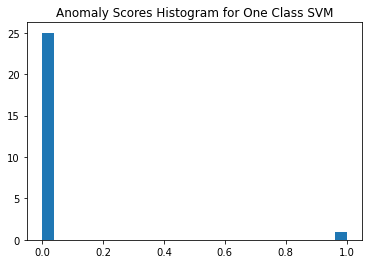

,width,height,scores,class
0,25,24,0.000378,0
1,25,25,-0.212281,0
2,25,25,-0.212281,0
3,21,24,1.829124,0
4,24,24,0.222820,0
5,30,29,1.019183,0
6,25,25,-0.212281,0
7,25,25,-0.212281,0
8,27,29,-0.000153,0
9,25,29,-0.204299,0


In [32]:
# SVM
contamination = 0.04  # percentage of outliers
n_features = len(image_pixels.columns) # Number of features
n_train = len(image_pixels)  # number of training points

# data transformation
X_train_data = StandardScaler().fit_transform(image_pixels)
X_train_data = pd.DataFrame(X_train_data)

# train the model
clf = OCSVM(contamination=contamination)
clf.fit(X_train_data)

# Predict the anomaly scores
scores_pred = clf.decision_function(X_train_data)  
scores_pred = pd.Series(scores_pred)

# class prediction
y_pred = clf.predict(X_train_data)


# Plot the histogram
plt.hist(y_pred, bins=26)  
plt.title("Anomaly Scores Histogram for One Class SVM")
plt.show()

# displaying the final data
final_data = pd.concat([image_pixels,pd.Series(scores_pred),pd.Series(y_pred)],axis=1)
final_data.columns=['width','height','scores','class']
display(final_data)

As we can see, the model was able to find the abnormal data point, i.e., the image with the width=30 and height=22. 

Source: https://towardsdatascience.com/anomaly-detection-with-autoencoder-b4cdce4866a6

https://towardsdatascience.com/dimension-reduction-techniques-with-python-f36ca7009e5c

At a more profound level, I used PyOD to train and compare different models for the current data. I created the ground truth list for the current data points based on the previous results:
ground_truth= [ 0 0 0 0 0 0 0 0 0 ….1]
Then, based on each class prediction and the ground truth, I calculated the error for each model 
Here is the visualization of the results):


# Why Do We Apply Dimensionality Reduction to Find Outliers?

Don’t we lose some information, including the outliers, if we reduce the dimensionality? The answer is once the main patterns are identified, the outliers are revealed. Many distance-based techniques (e.g. KNNs) suffer the curse of dimensionality when they compute distances of every data point in the full feature space. High dimensionality have to be reduced. Interestingly, during the process of dimensionality reduction outliers are identified. We can say outlier detection is a by-product of dimension reduction.


# Autoencoders?

There are already many useful tools such as Principal Component Analysis (PCA) to detect outliers, why do we need the autoencoders? Recall that the PCA uses linear algebra to transform (see this article “Dimension Reduction Techniques with Python”). In contrast, the autoencoder techniques can perform non-linear transformations with their non-linear activation function and multiple layers. It is more efficient to train several layers with an autoencoder, rather than training one huge transformation with PCA. The autoencoder techniques thus show their merits when the data problems are complex and non-linear in nature.

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_56 (Dense)            (None, 2)                 6         
                                                                 
 dropout_49 (Dropout)        (None, 2)                 0         
                                                                 
 dense_57 (Dense)            (None, 2)                 6         
                                                                 
 dropout_50 (Dropout)        (None, 2)                 0         
                                                                 
 dense_58 (Dense)            (None, 25)                75        
                                                                 
 dropout_51 (Dropout)        (None, 25)                0         
                                                                 
 dense_59 (Dense)            (None, 10)               

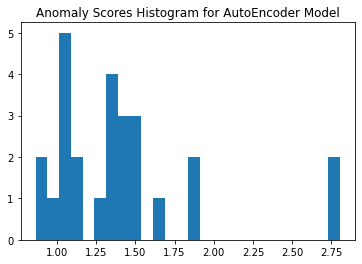

,width,height,scores,class
0,25,24,1.403138,0
1,25,25,1.029695,0
2,25,25,1.029695,0
3,21,24,2.806058,1
4,24,24,1.668812,0
5,30,29,1.908409,1
6,25,25,1.029695,0
7,25,25,1.029695,0
8,27,29,0.967420,0
9,25,29,1.139015,0


In [33]:
# AutoEncoder
contamination = 0.04  # percentage of outliers
n_features = len(image_pixels.columns) # Number of features

# Creating a dataframe with 20%
# values of original dataframe
# X_test_data = image_pixels.sample(frac = 0.2)
 
# Creating dataframe with
# rest of the 80% values
# X_train_data = image_pixels.drop(X_test_data.index)
n_train = len(image_pixels)  # number of training points

# data transformation
X_train_data = StandardScaler().fit_transform(image_pixels)
X_train_data = pd.DataFrame(X_train_data)
# train the model 
clf = AutoEncoder(hidden_neurons =[25, 10,2, 10, 25])
clf.fit(X_train_data)

# Predict the anomaly scores
scores_pred = clf.decision_function(X_train_data)  
scores_pred = pd.Series(scores_pred)

# class prediction
y_pred = clf.predict(X_train_data)
# Predict the anomaly scores on test
# y_test_scores = clf.decision_function(X_test_data)  
# y_test_scores = pd.Series(y_test_scores)

# Plot the histogram
plt.hist(scores_pred, bins=26)  
plt.title("Anomaly Scores Histogram for AutoEncoder Model")
plt.show()

# displaying the final data
final_data = pd.concat([image_pixels,pd.Series(scores_pred),pd.Series(y_pred)],axis=1)
final_data.columns=['width','height','scores','class']
display(final_data)

Number of inliers: 25
Number of outliers: 1
Ground truth shape is (26,). Outlier are 1 and inliers are 0.

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1] 

Model 1 Cluster-based Local Outlier Factor (CBLOF)
Model 2 Histogram-base Outlier Detection (HBOS)
Model 3 Isolation Forest
Model 4 K Nearest Neighbors (KNN)
Model 5 Average KNN
Model 6 Median KNN
Model 7 One-class SVM (OCSVM)
Model 8 Principal Component Analysis (PCA)

1 fitting Cluster-based Local Outlier Factor (CBLOF)

2 fitting Histogram-base Outlier Detection (HBOS)

3 fitting Isolation Forest

4 fitting K Nearest Neighbors (KNN)

5 fitting Average KNN

6 fitting Median KNN

7 fitting One-class SVM (OCSVM)

8 fitting Principal Component Analysis (PCA)


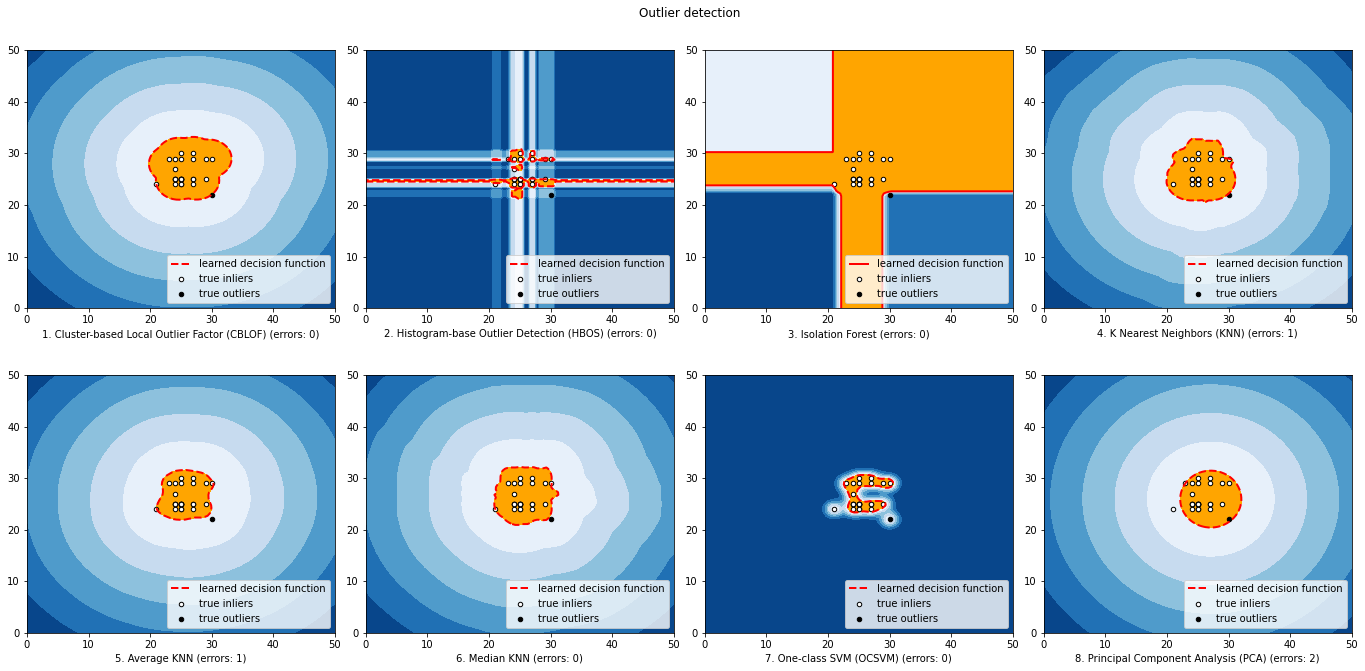

In [34]:
# Define the number of inliers and outliers
n_samples = 26
outliers_fraction = 0.04
clusters_separation = [0]

# Compare given detectors under given settings
# Initialize the data
xx, yy = np.meshgrid(np.linspace(0, 50, 100), np.linspace(0,50, 100))
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1
X=image_pixels.to_numpy()


# initialize a set of detectors for LSCP
detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
                 LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
                 LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
                 LOF(n_neighbors=50)]

# Show the statics of the data
print('Number of inliers: %i' % n_inliers)
print('Number of outliers: %i' % n_outliers)
print(
    'Ground truth shape is {shape}. Outlier are 1 and inliers are 0.\n'.format(
        shape=ground_truth.shape))
print(ground_truth, '\n')

random_state = np.random.RandomState(42)
# Define nine outlier detection tools to be compared
classifiers = {
#     'Angle-based Outlier Detector (ABOD)':
#         ABOD(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':
        CBLOF(contamination=outliers_fraction,
              check_estimator=False, random_state=random_state),
#     'Feature Bagging':
#         FeatureBagging(LOF(n_neighbors=5),
#                        contamination=outliers_fraction,
#                        random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                       contamination=outliers_fraction),
    'Median KNN': KNN(method='median',
                      contamination=outliers_fraction),
#     'Local Outlier Factor (LOF)':
#         LOF(n_neighbors=5, contamination=outliers_fraction),
#     'Local Correlation Integral (LOCI)':
#         LOCI(contamination=outliers_fraction),
#     'Minimum Covariance Determinant (MCD)': MCD(
#         contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state),
#     'Stochastic Outlier Selection (SOS)': SOS(
#         contamination=outliers_fraction),
#     'Locally Selective Combination (LSCP)': LSCP(
#         detector_list, contamination=outliers_fraction,
#         random_state=random_state),
    # 'Connectivity-Based Outlier Factor (COF)':
    #     COF(n_neighbors=5, contamination=outliers_fraction),
#     'Subspace Outlier Detection (SOD)':
#         SOD(contamination=outliers_fraction),
}

# Show all detectors
for i, clf in enumerate(classifiers.keys()):
    print('Model', i + 1, clf)

# Fit the models with the generated data and
# compare model performances
# for i, offset in enumerate(clusters_separation):
#     np.random.seed(42)
#     # Data generation
#     X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
#     X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
#     X = np.r_[X1, X2]
#     # Add outliers
#     X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model
plt.figure(figsize=(20, 15))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    print()
    print(i + 1, 'fitting', clf_name)
    # fit the data and tag outliers
    clf.fit(X)
    scores_pred = clf.decision_function(X) * -1
    y_pred = clf.predict(X)
    threshold = percentile(scores_pred, 100 * outliers_fraction)
    n_errors = sum(y_pred != ground_truth)
    # plot the levels lines and the points

    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
    subplot = plt.subplot(3, 4, i + 1)
    subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                     cmap=plt.cm.Blues_r)
    a = subplot.contour(xx, yy, Z, levels=[threshold],
                        linewidths=2, colors='red')
    subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                     colors='orange')
    b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                        s=20, edgecolor='k')
    c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                        s=20, edgecolor='k')
    subplot.axis('tight')
    subplot.legend(
        [a.collections[0], b, c],
        ['learned decision function', 'true inliers', 'true outliers'],
        prop=matplotlib.font_manager.FontProperties(size=10),
        loc='lower right')
    subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
    subplot.set_xlim((0, 50))
    subplot.set_ylim((0, 50))
plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
plt.suptitle("Outlier detection")
plt.savefig('ALL.png', dpi=300)
plt.show()

In [35]:

# plt.figure(figsize=(20, 15))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    print()
    print(i + 1, 'fitting', clf_name)
    # fit the data and tag outliers
    clf.fit(X)
#     scores_pred = clf.decision_function(X) * -1
    scores_pred = clf.decision_function(X)
    y_pred = clf.predict(X)
#     print(y_pred)
    final_data = pd.concat([image_pixels,pd.Series(scores_pred),pd.Series(y_pred)],axis=1)
    final_data.columns=['width','height','scores','class']
    display(final_data)
#     # plot the levels lines and the points
#     subplot = plt.subplot(3, 4, i + 1)
#     subplot.hist(scores_pred, bins=26)  
#     subplot.set_title("%s" % clf_name)
# plt.show()


1 fitting Cluster-based Local Outlier Factor (CBLOF)


,width,height,scores,class
0,25,24,0.714286,0
1,25,25,0.285714,0
2,25,25,0.285714,0
3,21,24,3.231099,0
4,24,24,1.200000,0
5,30,29,0.500000,0
6,25,25,0.285714,0
7,25,25,0.285714,0
8,27,29,0.500000,0
9,25,29,0.790569,0



2 fitting Histogram-base Outlier Detection (HBOS)


,width,height,scores,class
0,25,24,2.599850,0
1,25,25,1.714309,0
2,25,25,1.714309,0
3,21,24,4.363351,0
4,24,24,3.043152,0
5,30,29,3.794898,0
6,25,25,1.714309,0
7,25,25,1.714309,0
8,27,29,3.036813,0
9,25,29,2.409244,0



3 fitting Isolation Forest


,width,height,scores,class
0,25,24,-0.242264,0
1,25,25,-0.303314,0
2,25,25,-0.303314,0
3,21,24,-0.000000,0
4,24,24,-0.208879,0
5,30,29,-0.093884,0
6,25,25,-0.303314,0
7,25,25,-0.303314,0
8,27,29,-0.184586,0
9,25,29,-0.203076,0



4 fitting K Nearest Neighbors (KNN)


,width,height,scores,class
0,25,24,1.000000,0
1,25,25,0.000000,0
2,25,25,0.000000,0
3,21,24,3.162278,0
4,24,24,1.000000,0
5,30,29,4.123106,0
6,25,25,0.000000,0
7,25,25,0.000000,0
8,27,29,2.236068,0
9,25,29,2.000000,0



5 fitting Average KNN


,width,height,scores,class
0,25,24,0.600000,0
1,25,25,0.000000,0
2,25,25,0.000000,0
3,21,24,2.497367,0
4,24,24,0.800000,0
5,30,29,2.257077,0
6,25,25,0.000000,0
7,25,25,0.000000,0
8,27,29,1.447214,0
9,25,29,1.200000,0



6 fitting Median KNN


,width,height,scores,class
0,25,24,1.000000,0
1,25,25,0.000000,0
2,25,25,0.000000,0
3,21,24,3.162278,0
4,24,24,1.000000,0
5,30,29,3.000000,0
6,25,25,0.000000,0
7,25,25,0.000000,0
8,27,29,2.000000,0
9,25,29,1.000000,0



7 fitting One-class SVM (OCSVM)


,width,height,scores,class
0,25,24,-0.000348,0
1,25,25,0.000046,0
2,25,25,0.000046,0
3,21,24,0.407589,0
4,24,24,0.000186,0
5,30,29,0.010542,0
6,25,25,0.000046,0
7,25,25,0.000046,0
8,27,29,0.000340,0
9,25,29,-0.000277,0



8 fitting Principal Component Analysis (PCA)


,width,height,scores,class
0,25,24,5.732284,0
1,25,25,5.083558,0
2,25,25,5.083558,0
3,21,24,12.375940,1
4,24,24,7.263403,0
5,30,29,7.976523,0
6,25,25,5.083558,0
7,25,25,5.083558,0
8,27,29,5.442419,0
9,25,29,7.001997,0


As we can see, PCA, KNN, and Average KNN do not work well on this data as we expected. As we expected, they could not find the abnormal data. 

One disadvantage of the above methods is that we have to give the contamination fraction as an input, which then makes the model biased toward the manual input. One way to solve this issue is (of course, when having more data) to do a train/validation/test split among with the cross-validation on the data, and then evaluate the models based on the scores on the validation sets. 